In [2]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')

    !pip install umap-learn
    !pip install umap-learn[plot]
    !pip install holoviews

    !pip install joypy

    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"
    root_path = "/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido"
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import gc
import pandas as pd
import joypy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

import torch
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datetime import timedelta

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/dist

In [4]:
root_audios_Zamuro = f"{root}/Zamuro/Complementary_Files/zamuro_audios.csv"
root_recorders_Zamuro = f"{root}/Zamuro/Complementary_Files/zamuro_recorders.csv"
root_ai_Zamuro = f"{root}/Zamuro/AI_Caract/AI_Zamuro.csv"

audios = pd.read_csv(root_audios_Zamuro, index_col=0)
recorders = pd.read_csv(root_recorders_Zamuro, index_col=0)
df_ai = pd.read_csv(root_ai_Zamuro, index_col=0)
df_ai.dropna(inplace=True)
df_ai.set_index("file",inplace=True, drop=True)
df_ai.drop(columns=["Date"], inplace=True)
df_ai = df_ai.reset_index(drop=False)
df_ai.rename(columns={"file":"y"}, inplace=True)
y = df_ai.pop('y') 
df_ai['y'] = y 
df_ai['rain_FI'] = df_ai.index.map(audios['rain_FI'])

def combinar_nombre_ubicacion(row):
    return f"{row['field_number_PR']}_{row['Filename']}"

# Aplicando la función a cada fila del DataFrame para crear la nueva columna
audios['Filename_'] = audios.apply(combinar_nombre_ubicacion, axis=1)

audios.set_index("Filename_", inplace=True)

In [5]:
def extract_parts(row):
    parts = row.split('_')
    location = parts[0]
    date = parts[1]
    time = parts[2].split('.')[0]  # Eliminar la extensión .WAV
    day = date[-2:]  # Últimos dos caracteres para el día
    hour = time[:2]
    return pd.Series([location, day, hour])

# Aplicar la función a la columna 'y' y crear nuevas columnas
df_ai[['location', 'day', 'hour']] =df_ai['y'].apply(extract_parts)

def define_hour_stage(hour):
    hour = int(hour)
    if 5 <= hour <= 8:
        return 'morning'
    elif 9 <= hour <= 16:
        return 'day'
    else:
        return 'night'

df_ai['hour_stage'] =df_ai['hour'].apply(define_hour_stage)
df_ai.set_index("y", inplace=True, drop=False)
df_ai['cover'] = df_ai.index.map(audios['cover'])
df_ai = df_ai[df_ai['rain_FI'] == 'NO']
df_ai = df_ai.dropna()

In [43]:
df_ai

,ZCR,MEANt,VARt,SKEWt,KURTt,LEQt,BGNt,SNRt,MED,Ht,...,AGI,ROItotal,ROIcover,y,rain_FI,location,day,hour,hour_stage,cover
y,,,,,,,,,,,,,,,,,,,,,
RZUA01_20220903_104500.WAV,33413.633333,6.052836e-19,0.000803,0.463214,125.785312,62.065186,-25.232251,3.907083,0.054750,0.854772,...,1.371307,699,11.697134,RZUA01_20220903_104500.WAV,NO,RZUA01,03,10,day,pasture
RZUA01_20220903_113000.WAV,27640.366667,-7.398017e-19,0.002167,0.046234,22.329493,66.379409,-17.784118,2.163875,0.129061,0.940839,...,1.288866,522,1.293209,RZUA01_20220903_113000.WAV,NO,RZUA01,03,11,day,pasture
RZUA01_20220903_114500.WAV,30457.066667,1.426097e-18,0.008934,0.011160,11.288357,72.530919,-11.185479,1.877146,0.275884,0.961699,...,1.358705,1213,0.604688,RZUA01_20220903_114500.WAV,NO,RZUA01,03,11,day,pasture
RZUA01_20220903_180000.WAV,26602.833333,6.055727e-19,0.000455,0.048461,103.370373,59.598129,-26.396262,4.286802,0.047884,0.847441,...,1.367189,1714,5.867066,RZUA01_20220903_180000.WAV,NO,RZUA01,03,18,night,pasture
RZUA01_20220903_181500.WAV,16407.600000,-5.003039e-19,0.000985,0.080386,17.124613,62.954323,-22.284621,1.648931,0.076872,0.933467,...,1.304565,1809,4.308646,RZUA01_20220903_181500.WAV,NO,RZUA01,03,18,night,pasture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RZUH13_20220912_070000.WAV,37127.500000,2.395268e-19,0.000028,-0.123534,4.308900,47.563859,-36.848782,0.656902,0.014373,0.986157,...,1.213904,1877,0.920458,RZUH13_20220912_070000.WAV,NO,RZUH13,12,07,morning,pasture
RZUH13_20220912_071500.WAV,42607.800000,-5.329456e-21,0.000021,-0.147668,3.495183,46.161754,-37.072927,0.413386,0.014007,0.990583,...,1.213884,1829,1.042269,RZUH13_20220912_071500.WAV,NO,RZUH13,12,07,morning,pasture
RZUH13_20220912_073000.WAV,43009.266667,7.441964e-20,0.000019,-0.064865,4.044839,45.871403,-37.762048,0.553588,0.012939,0.988978,...,1.217297,2570,1.936579,RZUH13_20220912_073000.WAV,NO,RZUH13,12,07,morning,pasture


In [61]:
df_ai.to_csv('df_ai.csv', index=False) 
prueba = pd.read_csv("df_ai.csv")
prueba.set_index("y")


,ZCR,MEANt,VARt,SKEWt,KURTt,LEQt,BGNt,SNRt,MED,Ht,...,RAOQ,AGI,ROItotal,ROIcover,rain_FI,location,day,hour,hour_stage,cover
y,,,,,,,,,,,,,,,,,,,,,
RZUA01_20220903_104500.WAV,33413.633333,6.052836e-19,0.000803,0.463214,125.785312,62.065186,-25.232251,3.907083,0.054750,0.854772,...,0.317710,1.371307,699,11.697134,NO,RZUA01,3,10,day,pasture
RZUA01_20220903_113000.WAV,27640.366667,-7.398017e-19,0.002167,0.046234,22.329493,66.379409,-17.784118,2.163875,0.129061,0.940839,...,0.297566,1.288866,522,1.293209,NO,RZUA01,3,11,day,pasture
RZUA01_20220903_114500.WAV,30457.066667,1.426097e-18,0.008934,0.011160,11.288357,72.530919,-11.185479,1.877146,0.275884,0.961699,...,0.286141,1.358705,1213,0.604688,NO,RZUA01,3,11,day,pasture
RZUA01_20220903_180000.WAV,26602.833333,6.055727e-19,0.000455,0.048461,103.370373,59.598129,-26.396262,4.286802,0.047884,0.847441,...,0.381408,1.367189,1714,5.867066,NO,RZUA01,3,18,night,pasture
RZUA01_20220903_181500.WAV,16407.600000,-5.003039e-19,0.000985,0.080386,17.124613,62.954323,-22.284621,1.648931,0.076872,0.933467,...,0.151191,1.304565,1809,4.308646,NO,RZUA01,3,18,night,pasture
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RZUH13_20220912_070000.WAV,37127.500000,2.395268e-19,0.000028,-0.123534,4.308900,47.563859,-36.848782,0.656902,0.014373,0.986157,...,0.384166,1.213904,1877,0.920458,NO,RZUH13,12,7,morning,pasture
RZUH13_20220912_071500.WAV,42607.800000,-5.329456e-21,0.000021,-0.147668,3.495183,46.161754,-37.072927,0.413386,0.014007,0.990583,...,0.473620,1.213884,1829,1.042269,NO,RZUH13,12,7,morning,pasture
RZUH13_20220912_073000.WAV,43009.266667,7.441964e-20,0.000019,-0.064865,4.044839,45.871403,-37.762048,0.553588,0.012939,0.988978,...,0.478226,1.217297,2570,1.936579,NO,RZUH13,12,7,morning,pasture


## All classification

Accuracy: 0.8142099863201094
f1: 0.7641572444593824
recall 0.742687859988627
[[0.12927497 0.05095759 0.02214432]
 [0.01496238 0.5377052  0.01658687]
 [0.0247948  0.05634405 0.14722982]]
[[1512  596  259]
 [ 175 6289  194]
 [ 290  659 1722]]


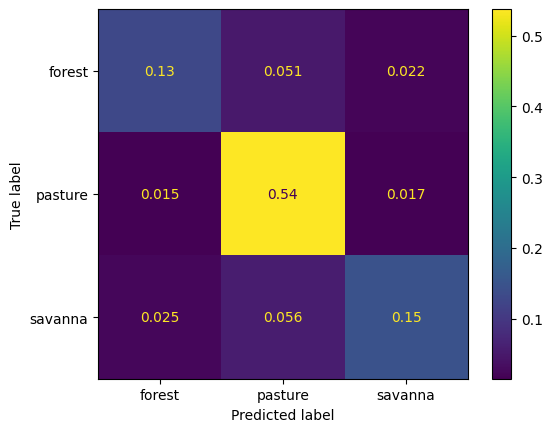

In [41]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns


X = np.asarray(df_ai.iloc[:,0:60])
y = np.asarray(df_ai.loc[:,"cover"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)

confusion_matrix_norm = metrics.confusion_matrix(y_test, y_pred_rf, normalize="all")

print(confusion_matrix_norm)

print(confusion_matrix)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_norm, display_labels = ["forest", "pasture", "savanna"])

# display matrix
cm_display.plot()
plt.show()



In [53]:
set(y_pred_rf)
a=0
for i in range(len(y_pred_rf)):
    if y_pred_rf[i] == "savanna":
        a+=1
        
print(a)

2175


In [50]:
a/len(y_pred_rf)

0.16903214774281805

In [52]:
a/len(y_pred_rf)

0.6450068399452804

In [54]:
a/len(y_pred_rf)

0.1859610123119015

## Cover classification

In [6]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

accuracies_ai_cover = []
f1_scores_ai_cover = []
recalls_ai_cover = []
df_day={}
for i in ["03","04","05","06","07","08","09","10","11","12","13"]:
    df_day = df_ai[df_ai['day'].isin([i])]
    X = np.asarray(df_day.iloc[:,0:60])
    y = np.asarray(df_day.loc[:,"cover"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)

    accuracies_ai_cover.append(accuracy)
    f1_scores_ai_cover.append(f1_score)
    recalls_ai_cover.append(recall)
    
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_ai_covers.npy", accuracies_ai_cover)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_ai_covers.npy", f1_scores_ai_cover)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_ai_covers.npy", recalls_ai_cover)

Accuracy: 0.843065693430657
f1: 0.7827223148007878
recall 0.7520036788858232
Accuracy: 0.8116438356164384
f1: 0.7167084157801332
recall 0.6792808292942955
Accuracy: 0.7949479940564635
f1: 0.731426150229848
recall 0.7079768215560196
Accuracy: 0.7813134732566012
f1: 0.726482400972103
recall 0.6998966242445531
Accuracy: 0.7822525597269625
f1: 0.7116749469341984
recall 0.6819293687667862
Accuracy: 0.7393689986282579
f1: 0.6657117774040135
recall 0.6452430073119728
Accuracy: 0.8248384781048098
f1: 0.7697329769720662
recall 0.750074673111483
Accuracy: 0.8197492163009404
f1: 0.7796119978082019
recall 0.7613031553953743
Accuracy: 0.8040600176522507
f1: 0.74890291090923
recall 0.7203703272966355
Accuracy: 0.8317503392130258
f1: 0.766022658903163
recall 0.7392045660783465
Accuracy: 0.809322033898305
f1: 0.7190864372449437
recall 0.6827081709876932


## Hour Stage Classification

In [7]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

accuracies_ai_hour = []
f1_scores_ai_hour = []
recalls_ai_hour = []
df_day={}
for i in ["03","04","05","06","07","08","09","10","11","12","13"]:
    df_day = df_ai[df_ai['day'].isin([i])]
    X = np.asarray(df_day.iloc[:,0:60])
    y = np.asarray(df_day.loc[:,"hour_stage"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)

    accuracies_ai_hour.append(accuracy)
    f1_scores_ai_hour.append(f1_score)
    recalls_ai_hour.append(recall)
    
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_ai_hours.npy", accuracies_ai_hour)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_ai_hours.npy", f1_scores_ai_hour)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_ai_hours.npy", recalls_ai_hour)

Accuracy: 0.8722627737226277
f1: 0.5901824580902103
recall 0.5993681245479806
Accuracy: 0.8344748858447488
f1: 0.7495470903278063
recall 0.7281976258934785
Accuracy: 0.7622585438335809
f1: 0.6576204816934182
recall 0.6496957905079777
Accuracy: 0.8151658767772512
f1: 0.7586119207633152
recall 0.7500957157461342
Accuracy: 0.837542662116041
f1: 0.7810983625236251
recall 0.7733143081442849
Accuracy: 0.8024691358024691
f1: 0.7325062597095365
recall 0.7233307027200158
Accuracy: 0.7544867193108399
f1: 0.6986502050338498
recall 0.6927747155392202
Accuracy: 0.7264890282131662
f1: 0.6310774201570873
recall 0.6258439314789576
Accuracy: 0.8014121800529568
f1: 0.7392090197928938
recall 0.7292819784810821
Accuracy: 0.8018995929443691
f1: 0.763874538967046
recall 0.7563480770197005
Accuracy: 0.75
f1: 0.6983124125981268
recall 0.6896383186705767


### Acoustic Indices Data

In [ ]:
X_ai = []
remove = []
s=0
for i in range(len(y_3)):
    
    try:
        X_ai.append(ai.loc[y_3[i]])
    except:
        s+=1
        remove.append(y_3[i])
for i in range(len(remove)):
    y_3.remove(remove[i])
X_ai = np.asarray(X_ai)

labels_ai = []
# audios.set_index("Filename", inplace=True)
for i in range(len(y_3)):
    labels_ai.append(audios.loc[y_3[i], "cover"])
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_ai, labels_ai, test_size=0.2,random_state=0)

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy_ai = metrics.accuracy_score(y_test, y_pred_rf)
f1_score_ai = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall_ai = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy_ai)
print("f1:", f1_score_ai)
print("recall", recall_ai)

# Autoencoders Features and Labels using mean of segments

In [ ]:
X_New = np.load(f"temporal_zamuro/Features/X_ae_norm_new.npy")
y_New = np.load(f"temporal_zamuro/Features/y_ae_norm_new.npy")
labels_aenew = audios.loc[y_New]
labels_aenew = list(labels_aenew["cover"])


In [ ]:
X_B =np.asarray(X_2)
X_B.shape

In [ ]:
X_New = np.mean(X_B, axis=1)
# X_New = X_New[0:len(y_3)]
# y_New = y_New[0:len(y_3)]

X_New.shape

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for F1 scores, recall, and accuracy
methods = ["Acoustic\nIndices", "AE Normalized", "vggish"]

# Create an array for the x-axis positions
x = np.arange(len(methods))

# Set the figure size
plt.figure(figsize=(11, 6))

# Width of the bars
bar_width = 0.2

# Define professional color palettes
f1_color = 'steelblue'  # You can adjust the color as needed
recall_color = 'indianred'  # You can adjust the color as needed
accuracy_color = 'orange'  # You can adjust the color as needed

# Create the bar chart for F1 scores
bars_f1 = plt.bar(x - bar_width, f1_scores, bar_width, label='F1 Score', color=f1_color)

# Create the bar chart for recall
bars_recall = plt.bar(x, recall_scores, bar_width, label='Recall', color=recall_color)

# Create the bar chart for accuracy
bars_accuracy = plt.bar(x + bar_width, accuracy_scores, bar_width, label='Accuracy', color=accuracy_color)

# Set the y-axis limits
plt.ylim(0.5, 1)

# Set the x-axis labels and their positions
plt.xticks(x, methods, fontsize=14)  # Increase label size

# Set the y-axis label
plt.ylabel('Score')

# Set the title
# plt.title('F1 Score, Recall, and Accuracy Comparison')

# Set the legend with increased size
plt.legend(fontsize=14)  # Increase legend size

# Add values on top of the bars
for bar, value in zip(bars_f1, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.01, f'{value:.3f}', ha='center', va='bottom', fontsize=11, rotation=90)

for bar, value in zip(bars_recall, recall_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.01, f'{value:.3f}', ha='center', va='bottom', fontsize=11, rotation=90)

for bar, value in zip(bars_accuracy, accuracy_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.01, f'{value:.3f}', ha='center', va='bottom', fontsize=11, rotation=90)

# Add a legend
# plt.legend()

# Display the figure

# plt.savefig(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/zamuro_classification.pdf", format="pdf")